<a href="https://colab.research.google.com/github/mazinkamal134/DS_MRP_2024/blob/main/Demographics%20Pipeline/Demographics_Age_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.5 MB/s eta 0:00:00


### Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import html
import pickle
import contractions
import emoji

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('vader_lexicon')

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Word Embeddings
from gensim.models import KeyedVectors  # For loading GloVe embeddings
from gensim.scripts.glove2word2vec import glove2word2vec  # For converting GloVe embeddings to Word2Vec format

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Text Cleaning

In [ ]:
# Function to clean the text (user description)
def clean_text(text):

    # regex
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_%]')
    URLs = re.compile(r"http\S+|www\S+|https\S+")
    HASHTAG = re.compile(r"#\w+")
    EMOJIS = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002500-\U00002BEF"  # Other symbols
        "\U0001F004"             # Mahjong Tile Red Dragon
        "\U0001F0CF"             # Playing Card Black Joker
        "\U0001F018-\U0001F270"  # Various Asian characters
        "\U0001F201-\U0001F251"  # Enclosed characters
        "\U0001F926-\U0001F937"  # Additional emoji
        "\U0001F97C-\U0001F9FF"  # Additional emoji
        "\U0001F9E0-\U0001F9E6"  # Additional emoji
        "\U0001F680-\U0001F6C5"  # Transport and map symbols
        "\U0001F6F4-\U0001F6F8"  # Additional transport and map symbols
        "\U0001F7E0-\U0001F7EB"  # Additional symbols
        "\U0001F90D-\U0001F93A"  # Additional emoji
        "\U0001F93C-\U0001F945"  # Additional emoji
        "\U0001F947-\U0001F978"  # Additional emoji
        "\U0001F97A-\U0001F9CB"  # Additional emoji
        "\U0001F9CD-\U0001FA6D"  # Additional emoji
        "\U0001FA60-\U0001FA6D"  # Additional emoji
        "\U0001FA70-\U0001FA74"  # Additional emoji
        "\U0001FA78-\U0001FA7A"  # Additional emoji
        "\U0001FA80-\U0001FA86"  # Additional emoji
        "\U0001FA90-\U0001FAA8"  # Additional emoji
        "\U0001FAB0-\U0001FAB6"  # Additional emoji
        "\U0001FAC0-\U0001FAC2"  # Additional emoji
        "\U0001FAD0-\U0001FAD6"  # Additional emoji
        "\u200d"                 # Zero Width Joiner
        "\u2640-\u2642"          # Gender symbols
        "\u2600-\u2B55"          # Miscellaneous symbols and dingbats
        "\u23cf"                 # Eject symbol
        "\u23e9"                 # Fast forward
        "\u231a"                 # Watch
        "\ufe0f"                 # Dingbats
        "\u3030"                 # Wavy dash
        "\u00a9"                 # Copyright
        "\u00ae"                 # Registered
        "\u2122"                 # Trademark
        "]+", flags = re.UNICODE)

    # Replace contractions with their original form
    text = contractions.fix(text)
    # remove html related tokens
    text = html.unescape(text)
    # remove the line feeds
    text = re.sub(r"\n", " ", text)
    # lowercase text
    text = text.lower()
    # Remove emojis from the text using the pattern
    text = EMOJIS.sub(" ", text)
    # Substitute the matched string in URLs with space.
    text = URLs.sub(" ", text)
    # Substitute the matched string in HASHTAG with space.
    text = HASHTAG.sub(" ", text)
    # Substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = REPLACE_BY_SPACE_RE.sub(" ", text)
    # Substitute the matched string in BAD_SYMBOLS_RE with space.
    text = BAD_SYMBOLS_RE.sub(" ", text)
    # Trim the text
    text = text.strip()

    return text

### Global Params

In [ ]:
authorsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Authors"
tweetsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Tweets"
embeddingDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Demographics/Word Embeddings"
demographicsDir = "/content/drive/MyDrive/Master-2024/MRP/Data/Demographics"

### Data

#### Users

In [ ]:
# Read the data
usersDf = pd.read_parquet(os.path.join(authorsDir, "Authors.parquet"))
# Clean the required text
usersDf["description_cleaned"] = usersDf["description"].apply(clean_text)
usersDf["name_cleaned"] = usersDf["name"].apply(clean_text)
"""
controlUsers = pd.read_csv(os.path.join(authorsDir, "authors_control.csv"))
# Add the group column
controlUsers["group"] = 0
print("Control users shape:", controlUsers.shape)
treatmentUsers = pd.read_csv(os.path.join(authorsDir, "authors_treatment.csv"))
treatmentUsers["group"] = 1
print("Treatment users shape:", treatmentUsers.shape)

# Combine
usersDf = pd.concat([controlUsers, treatmentUsers])

# Remove the unnecessary columns
usersDf.drop(["anonymized_id", "matched_author_count", "matched_author_ids", "location", "username"], axis = 1, inplace = True)

# Fix the datatypes
usersDf["created_at"] = pd.to_datetime(usersDf["created_at"]).dt.tz_localize(None)
# find the account age
usersDf["account_age"] = (pd.to_datetime("today") - usersDf["created_at"]).dt.days/365.0
# Fill na
usersDf["account_age"].fillna(0, inplace = True)
toFill = ["followers_count", "following_count", "tweet_count"]
# Fill and convert to int
usersDf[toFill] = usersDf[toFill].fillna(0)
usersDf["followers_count"] = usersDf["followers_count"].astype("int64")
usersDf["following_count"] = usersDf["following_count"].astype("int64")
usersDf["tweet_count"] = usersDf["tweet_count"].astype("int64")

# Fill the rest of columns with nothing
usersDf.fillna("", inplace = True)

# Clean the required text
usersDf["description_cleaned"] = usersDf["description"].apply(clean_text)

# find the length of the description field
usersDf["description_len"] = usersDf["description"].apply(lambda x: len(x.split()))
usersDf["name_cleaned"] = usersDf["name"].apply(clean_text)

# Reorganize the columns
reOrg = ['id', 'created_at', "account_age", 'verified', 'name', 'name_cleaned', 'description',
       'description_cleaned', "description_len", 'disorder', 'group', 'followers_count', 'following_count', 'tweet_count']
usersDf = usersDf[reOrg]
# Rename id to author_id
usersDf.rename({"id":"author_id"}, axis = 1, inplace = True)
# Change the author_id data type to str
usersDf["author_id"] = usersDf["author_id"].astype("str")
"""
# Check
print("Full dataset shape:", usersDf.shape)

Full dataset shape: (5612, 15)


#### Tweets

In [ ]:
# Load the tweets parquet file
tweetsDf = pd.read_parquet(os.path.join(tweetsDir, "processedTweets.parquet"))
print("Original tweets shape:", tweetsDf.shape)
# Remove other languages + remove the missing text, and only focus on timeline tweets
# Commented part is to account for some control users without timeline tweets
tweetsDf = tweetsDf[(tweetsDf.cleaned_text.notna()) &
 #(tweetsDf.tweet_type == "timeline") &
  #(tweetsDf.referenced_tweet_type != "quoted") &
    (tweetsDf.lang == "en")]
# Join with the users
tweetsDf = tweetsDf.merge(usersDf[["author_id"]], on = "author_id", how = "inner")
print("Filtered tweets shape:", tweetsDf.shape)

# Sort for further processing
tweetsDf = tweetsDf.sort_values(by = ["author_id", "created_at"], ascending = [True, False])
print("Tweets shape:", tweetsDf.shape)

Original tweets shape: (15542629, 28)
Filtered tweets shape: (8025384, 28)
Tweets shape: (8025384, 28)


#### RegEx on Description

In [ ]:
# Function to extract age from text (self-reporting): On user description
def extract_age(text):
    patterns = [
        r'\b(?:i\'m|i am|am|im|age|years old|yrs old|years old|yrs old|yo)\s*(1[0-9]|2[0-9]|3[0-9]|4[0-9]|5[0-9]|6[0-9]|7[0-5])\b',
        r'\b(1[0-9]|2[0-9]|3[0-9]|4[0-9]|5[0-9]|6[0-9]|7[0-5])\s*(?:years old|yrs old|yo)\b',
        r'^(1[0-9]|2[0-9]|3[0-9]|4[0-9]|5[0-9]|6[0-5])\b(?:\s+\w+)*$'
    ]
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return int(match.group(1))
    return None

In [ ]:
# Extract the age
usersDf["age"] = usersDf["description_cleaned"].apply(extract_age)

# Categorixe based on GenZ and Millineals
def categorize_age(age):
    if 12 < age <= 25:
        return "Gen-Z"
    elif 25 < age <= 65:
        return "Millenial"

# Apply the function above
usersDf["age_group"] = usersDf["age"].apply(categorize_age)

# % of extracted ages
print("% of users with age in their descriptions", round(usersDf[~usersDf.age.isna()].shape[0]/usersDf.shape[0], 2)*100, "%")
# Groups
usersDf["age_group"].value_counts()

% of users with age in their descriptions 6.0 %


,count
age_group,
Gen-Z,257
Millenial,85


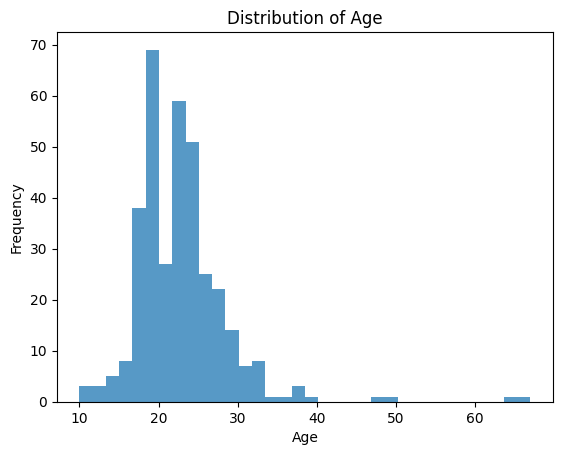

In [ ]:
# plot
plt.hist(usersDf.age, bins = "auto", alpha = 0.75)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title(f"Distribution of Age")
plt.show()

#### RegEx on Tweets

"Iam 23 today, happy birthday to me",
"I'm turning 23 today",
"Just turned 23",
"I am 23 years old",
"Celebrating my 23rd birthday",
"I am finally 23",
"Im 23 today",
"I m turning 23",
"Today is my 23rd birthday",
"23 years old today",
"I'm 23 years old",
"I am 23",
"I just turned 23",
"Turning 23 today",
"Feeling great at 23",
"Happy 23rd to me",
"23 years young today",
"HBD to me 23",
"No age mentioned here"


In [ ]:
def extract_age_from_tweet(text):
    age_patterns = [
        # r"I(?:'m|'m| m| am| turned| turn| am turning| turning| will be| am going to be) (\d{1,3})(?: years old| today| yrs old| yo| y\.o\.| this year)?",
        # r"happy (\d{1,3})(?:th|st|nd|rd)? birthday (?:to me|to myself|to yours truly)",
        # r"HBD (?:to me|to myself|to yours truly) (?:I'm|turning) (\d{1,3})",
        # r"(\d{1,3}) years (?:young|old) today",
        # r"(?:turning|turned) the big (\d{1,3})",
        # r"it's my (\d{1,3})(?:th|st|nd|rd)? birthday",
        # r"just turned (\d{1,3})",

        r'\b[Ii](?:\s|\'|a?m|[A-Za-z])*\s(\d{1,2})\s(?:today|this\s(?:birthday|year))\b',
        r'\b[Ii](?:\s|\'|a?m|[A-Za-z])*\sturning\s(\d{1,2})\s(?:today|this\s(?:birthday|year))\b',
        r'\bJust\s(?:turned|turning)\s(\d{1,2})\b',
        r'\b[Ii](?:\s|\'|a?m|[A-Za-z])*\s(\d{1,2})\syears?\sold\b',
        r'\bCelebrating\s(?:my\s)?(\d{1,2})(?:st|nd|rd|th)\sbirthday\b',
        r'\b[Ii](?:\s|\'|a?m|[A-Za-z])*\sfinally\s(\d{1,2})\b',
        r'\b[Ii]\'?m\s(\d{1,2})\s(?:today|this\s(?:birthday|year))\b',
        r'\bTurning\s(\d{1,2})\s(?:today|this\s(?:birthday|year))\b',
        r'\bToday\sis\s(?:my\s)?(\d{1,2})(?:st|nd|rd|th)\sbirthday\b',
        r'\b(\d{1,2})\syears?\sold\b',
        r'\b(\d{1,2})\syears?\syoung\s(?:today|this\s(?:birthday|year))\b',
        r'\bHBD\s(?:to\sme|me)\s(\d{1,2})\b'
    ]

    for pattern in age_patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            age = int(match.group(1))
            return age

    return None  # No age found

In [ ]:
# Exclude the already inferred users
usersNoAgeDf = usersDf[usersDf["age"].isna()]
print("Users with no age:", usersNoAgeDf.shape[0])

# Join the users with no age with tweetsDf
tweetsAgeDf = tweetsDf.merge(usersNoAgeDf[["author_id"]], on = "author_id", how = "inner")
print("Tweets with no age:", tweetsAgeDf.shape[0])

Users with no age: 5263
Tweets with no age: 7528916


### Feature Engineering

#### Tweets features

In [ ]:
# Function to extract some tweet features
def extract_tweet_features(text):
    hashtag_pattern = r"#\w+"
    url_pattern = r"https?://\S+"
    mention_pattern = r"@\w+"

    hashtag_count = len(re.findall(hashtag_pattern, text))
    url_count = len(re.findall(url_pattern, text))
    mention_count = len(re.findall(mention_pattern, text))

    return {
        "hashtag_count": hashtag_count,
        "url_count": url_count,
        "mention_count": mention_count
    }

# Update the dataframe
tweetsDf["tweet_features"] = tweetsDf["cleaned_text"].apply(extract_tweet_features)
# Split the tweet_features into 3 different coloumns
tweetsDf[["auth_hashtag_count", "auth_url_count", "auth_mention_count"]] = pd.DataFrame(tweetsDf["tweet_features"].tolist(), index = tweetsDf.index)
# Drop tweets_fatures column
tweetsDf.drop("tweet_features", axis = 1, inplace = True)

# Find total number of tokens per tweet
tweetsDf["total_tokens"] = tweetsDf["cleaned_text"].apply(lambda x: len(x.split()))

# Fill na
tweetsDf["auth_hashtag_count"].fillna(0, inplace = True)
tweetsDf["auth_url_count"].fillna(0, inplace = True)
tweetsDf["auth_mention_count"].fillna(0, inplace = True)

# Aggregate at user level
engagementMetricsDf = tweetsDf.groupby("author_id").agg({
    "auth_hashtag_count": "sum",
    "auth_url_count": "sum",
    "auth_mention_count": "sum",
    "like_count": "sum",
    "retweet_count": "sum",
    "reply_count": "sum",
    "quote_count": "sum",
    "total_tokens": "mean"
}).reset_index().rename({"like_count": "auth_like_count", "retweet_count": "auth_retweet_count", "reply_count": "auth_reply_count", "quote_count": "auth_quote_count", "total_tokens": "auth_avg_tokens"}, axis = 1)

# Combine with the userDf
usersDf = usersDf.merge(engagementMetricsDf, on = "author_id", how = "left")

#### Time features

In [ ]:
# Popular Posting Time (Categorical):
def categorize_time(hour):
    if 5 <= hour < 12:
        return "Early Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 22:
        return "Evening"
    elif 22 <= hour or hour < 5:  # Covers late night and after midnight
        return "Night"

# Aggregate by majority vote
def aggregate_by_majority_vote(group):
    modeResult = group.mode()
    return modeResult.iloc[0] if not modeResult.empty else None

tweetsDf['posting_time'] = tweetsDf['created_at'].dt.hour.apply(categorize_time)

# Average Time Between Tweets (per User):
tweetsDf['time_since_last_tweet'] = tweetsDf.sort_values(['author_id', 'created_at']).groupby('author_id')['created_at'].diff()

meanTimeBetweenTweets = tweetsDf.groupby('author_id')['time_since_last_tweet'].mean().dt.total_seconds() / 3600
meanTimeBetweenTweets = meanTimeBetweenTweets.reset_index(name = "mean_time_between_tweets")
# Fill null values
meanTimeBetweenTweets['mean_time_between_tweets'].fillna(0, inplace = True)
# drop the unnecessary column
tweetsDf.drop(columns = ["time_since_last_tweet"], inplace = True)

# Posting Day of Week (Categorical) and Weekend vs. Weekday (Binary):
tweetsDf['day_of_week'] = tweetsDf['created_at'].dt.day_name()

# Tweet Frequency (per User):
tweetFrequency = tweetsDf['author_id'].value_counts() / (tweetsDf['created_at'].max() - tweetsDf['created_at'].min()).days
tweetFrequency = tweetFrequency.reset_index(name = "tweet_frequency")

# Apply majority voting to each categorical feature
postingTime = tweetsDf.groupby('author_id')['posting_time'].apply(aggregate_by_majority_vote).reset_index()
dayOfWeek = tweetsDf.groupby('author_id')['day_of_week'].apply(aggregate_by_majority_vote).reset_index()

# Combine aggregated features into a single DataFrame
timeFeaturesPerUser = pd.DataFrame({
    'author_id': postingTime['author_id'],
    'fav_posting_time': postingTime['posting_time'],
    'fav_day_of_week': dayOfWeek['day_of_week'],
    "mean_time_between_tweets": meanTimeBetweenTweets['mean_time_between_tweets'],
    "tweet_frequency": tweetFrequency['tweet_frequency']
})

# merge back into the original tweets DataFrame
usersDf = usersDf.merge(timeFeaturesPerUser, on = 'author_id', how = 'left')

# Fill the na
mostFavPostingDay = usersDf.fav_day_of_week.value_counts().reset_index(name = "count").iloc[0]["fav_day_of_week"]
mostFavPostingTime = usersDf.fav_posting_time.value_counts().reset_index(name = "count").iloc[0]["fav_posting_time"]
usersDf = usersDf.fillna({"fav_day_of_week": mostFavPostingDay, "fav_posting_time": mostFavPostingTime})
# Use the fav_day_of_week to infer the weekend day
usersDf["is_weekend"] = usersDf.fav_day_of_week.isin(["Saturday", "Sunday"])

#### Most recent tweets

In [ ]:
# Get only the last n tweets of each user based on created_at and combine at user level
n = 200
recentTweetsDf = tweetsDf.groupby("author_id").head(n).reset_index()

# Aggregate on the last n tweets for each user
authorsWithTextDf = recentTweetsDf.groupby("author_id")["cleaned_text"].apply(lambda x: ". ".join(x)).reset_index()

# Add the lexical density for the tweets
authorsWithTextDf["lexical_density"] = authorsWithTextDf["cleaned_text"].apply(lambda x: len(set(x.split())) / len(x.split()))

# Duplicate the text column
authorsWithTextDf["original_text"] = authorsWithTextDf["cleaned_text"]
# Clean the aggregated tweets of each author
authorsWithTextDf["cleaned_text"] = authorsWithTextDf["cleaned_text"].apply(clean_text)

# Join with the usersDf on author_id
authorsWithTextDf = authorsWithTextDf.merge(usersDf[["author_id", "verified", "description_len", "account_age",
                                                     "followers_count", "following_count", "tweet_count",
                                                     "fav_posting_time", "fav_day_of_week", "mean_time_between_tweets", "tweet_frequency", "is_weekend",
                                                     "auth_hashtag_count", "auth_url_count", "auth_mention_count", "auth_like_count", "auth_retweet_count", "auth_reply_count", "auth_quote_count", "auth_avg_tokens",
                                                     "age", "age_group"]], on = "author_id", how = "inner")

print("Authors with text shape:", authorsWithTextDf.shape)

Authors with text shape: (5612, 25)


#### Linguistic fatures

In [ ]:
# Function to get POS tag counts for a tweet
def get_pos_tag_counts(text):
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    tag_counts = {}
    for word, tag in tagged_tokens:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1
    return tag_counts

# Apply the function to the 'cleaned_text' column
authorsWithTextDf['pos_tag_counts'] = authorsWithTextDf['cleaned_text'].astype(str).apply(get_pos_tag_counts)

# Define lists of relevant tags for each category
nouns = ['NN', 'NNS', 'NNP', 'NNPS']
verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
adjectives = ['JJ', 'JJR', 'JJS']
adverbs = ['RB', 'RBR', 'RBS']

# Count tags in a specific category
def count_tags(counts, tags):
    return sum(counts.get(tag, 0) for tag in tags)

# Create new columns for each part of speech
authorsWithTextDf["noun_tags"] = authorsWithTextDf["pos_tag_counts"].apply(lambda x: count_tags(x, nouns))
authorsWithTextDf["verb_tags"] = authorsWithTextDf["pos_tag_counts"].apply(lambda x: count_tags(x, verbs))
authorsWithTextDf["adjective_tags"] = authorsWithTextDf["pos_tag_counts"].apply(lambda x: count_tags(x, adjectives))
authorsWithTextDf["adverb_tags"] = authorsWithTextDf["pos_tag_counts"].apply(lambda x: count_tags(x, adverbs))
# Create a column for other tags
all_tags = nouns + verbs + adjectives + adverbs
authorsWithTextDf['other_tags'] = authorsWithTextDf['pos_tag_counts'].apply(lambda x: sum(count for tag, count in x.items() if tag not in all_tags))

#### Emoji's

In [ ]:
# Extract emojis from a tweet
def extract_emojis(text):
    return [c for c in text if c in emoji.EMOJI_DATA]

# Count emojis in a tweet
def count_emojis(text):
    return len(extract_emojis(text))

# Get sentiment of emojis in a tweet (using demojize and VADER)
sia = SentimentIntensityAnalyzer()
def emoji_sentiment(text):
    emoji_descriptions = " ".join([emoji.demojize(c) for c in extract_emojis(text)])
    return sia.polarity_scores(" ".join(emoji_descriptions.replace(":", "").split("_")))["compound"]

# Apply the functions to the 'cleaned_text' column
authorsWithTextDf["emojis"] = authorsWithTextDf["original_text"].apply(extract_emojis)
authorsWithTextDf["emoji_count"] = authorsWithTextDf["original_text"].apply(count_emojis)
authorsWithTextDf["emoji_sentiment"] = authorsWithTextDf["original_text"].apply(emoji_sentiment)

# Drop unnecessary columns
authorsWithTextDf.drop(["original_text", "pos_tag_counts", "emojis"], axis = 1, inplace = True)

In [ ]:
# Subject dataframe (will be used throught the section)
X = authorsWithTextDf[authorsWithTextDf.age_group.notna()].reset_index(drop = True)
X.drop(columns=["author_id", "age", "age_group"], inplace=True)

#### TF-IDF
Going forward, the idea is to create a unified dataframe with all features in one place (TF-IDF, Embedding, PCA, original features). Then keep/remove features as appropriate.

In [ ]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features = 10000, ngram_range = (1, 2), min_df = 0.05, max_df = 0.95, stop_words = "english")
X_tfidf = vectorizer.fit_transform(X["cleaned_text"])

# Create a DataFrame from the TF-IDF matrix
tfidfDf = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
tfidfFeatures = tfidfDf.columns.tolist()
# Check
print("TF-IDF shape:", tfidfDf.shape)

TF-IDF shape: (342, 2882)


#### Embedding

In [ ]:
# Load pre-trained GloVe embeddings for Twitter (adjust path if needed)
gloveFilePath = os.path.join(embeddingDir, "glove.twitter.27B.25d.txt")
tempFile = "temp_word2vec.txt"

# Convert GloVe to Word2Vec format (required for loading with Gensim)
glove2word2vec(gloveFilePath, tempFile)

# Load the converted embeddings
gloveModel = KeyedVectors.load_word2vec_format(tempFile, binary=False)

# Function to get GloVe representation of a tweet
def get_tweet_embedding(text):
    words = text.split()
    validWords = [word for word in words if word in gloveModel]
    if validWords:
        return np.mean(gloveModel[validWords], axis=0)
    else:
        return np.zeros(gloveModel.vector_size)

# Create GloVe embeddings for tweets
embeddings = X["cleaned_text"].apply(get_tweet_embedding)
# Convert to dataframe
embeddingDf = pd.DataFrame(embeddings.tolist(), columns = [f"embedding_{i}" for i in range(gloveModel.vector_size)])
# Get the feature names
embeddingFeatures = embeddingDf.columns.tolist()
# Check
print("Embeddings shape:", embeddingDf.shape)

<ipython-input-21-e2a5713482d7>:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(gloveFilePath, tempFile)


Embeddings shape: (342, 25)


#### PCA

In [ ]:
# Features
categoricalCols = ['fav_posting_time', 'fav_day_of_week']
numericalCols = ['verified', 'lexical_density', 'description_len', 'account_age',
                'followers_count', 'following_count', 'tweet_count',
                'mean_time_between_tweets', 'tweet_frequency', 'is_weekend',
                'auth_hashtag_count', 'auth_url_count', 'auth_mention_count', 'auth_like_count', 'auth_retweet_count', 'auth_reply_count', 'auth_quote_count', 'auth_avg_tokens',
                'noun_tags', 'verb_tags', 'adjective_tags', 'adverb_tags', 'other_tags',
                'emoji_count', 'emoji_sentiment']

# Create a ColumnTransformer to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericalCols),   # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categoricalCols), # One-hot encode categorical features
    ])

# Create a PCA pipeline:
pca = PCA()

# Combine preprocessing and PCA into a single pipeline:
pcaPipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca)])

# Fit the pipeline to the data:
pcaPipeline.fit(X)

# Get explained variance ratios
explainedVarRatio = pca.explained_variance_ratio_

# Determine the number of components to keep
cumulativeVarRatio = np.cumsum(explainedVarRatio)
nComponents = np.argmax(cumulativeVarRatio >= 0.95) + 1  # Keep components explaining 95% variance

# Transform the data using the selected number of components
X_pca = pcaPipeline.transform(X)[:, :nComponents]

# Create a DataFrame for the transformed data
pcaCols = [f'PC{i+1}' for i in range(nComponents)]
pcaDf = pd.DataFrame(X_pca, columns = pcaCols, index = X.index)

# get the selected features
pcaFeatures = pcaDf.columns.tolist()
# Check
print("PCA shape:", pcaDf.shape)

PCA shape: (342, 20)


#### Decomposed TF-IDF

In [ ]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features = 10000, ngram_range = (1, 2), min_df = 0.05, max_df = 0.95, stop_words = "english")
tfidfResult = vectorizer.fit_transform(X["cleaned_text"])

# Apply SVD (TruncatedSVD for sparse matrices)
svd = TruncatedSVD(n_components = 100)
svdResult = svd.fit_transform(tfidfResult)

# Create DataFrame with SVD results and original feature names
svdTfidfDf = pd.DataFrame(svdResult, columns=[f"svd_tfidf_{i}" for i in range(svdResult.shape[1])])

# Get the feature names
svdTfidfFeatures = svdTfidfDf.columns.tolist()
# Check
print("TF-IDF shape:", svdTfidfDf.shape)

TF-IDF shape: (342, 100)


#### Metadata

In [ ]:
# Create a ColumnTransformer to preprocess the data
categoricalCols = ['fav_posting_time', 'fav_day_of_week']
numericalCols = ['verified', 'lexical_density', 'description_len', 'account_age',
                'followers_count', 'following_count', 'tweet_count',
                'mean_time_between_tweets', 'tweet_frequency', 'is_weekend',
                'auth_hashtag_count', 'auth_url_count', 'auth_mention_count', 'auth_like_count', 'auth_retweet_count', 'auth_reply_count', 'auth_quote_count', 'auth_avg_tokens',
                'noun_tags', 'verb_tags', 'adjective_tags', 'adverb_tags', 'other_tags',
                'emoji_count', 'emoji_sentiment']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericalCols),   # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categoricalCols), # One-hot encode categorical features
    ])

processed = preprocessor.fit_transform(X)
metadataDf = pd.DataFrame(processed, columns = preprocessor.get_feature_names_out())
metadataFeatures = metadataDf.columns.tolist()
# Check
print("Metadata shape:", metadataDf.shape)

Metadata shape: (342, 36)


#### Combined Features

In [ ]:
# Get y and label encode it
y = authorsWithTextDf[authorsWithTextDf.age_group.notna()]["age_group"]
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), name="label")
classes = le.classes_

# Calculate scale_pos_weight
imbalanceRatio = y.value_counts()[0] / y.value_counts()[1]
print("Imbalance Ratio:", imbalanceRatio)

# Concatenate all features
finalMLDf = pd.concat([metadataDf, tfidfDf, embeddingDf, pcaDf, svdTfidfDf, y], axis = 1)
print("Final ML shape:", finalMLDf.shape)

Imbalance Ratio: 3.023529411764706
Final ML shape: (342, 3064)


### Machine Learning

#### Balancing
Run **one** of those only

##### SMOTE

In [ ]:
# Split the data into features and target
X = finalMLDf.drop(columns = ["label"])
y = finalMLDf["label"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Apply SMOTE to the training set (keep the test set as is)
smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Unify the dataframes
trainDf = pd.concat([X_train, y_train], axis = 1)
testDf = pd.concat([X_test, y_test], axis = 1)

# Check
print("Shape of the Resampled train df:", trainDf.shape)
print("Shape of the original test df:", testDf.shape)

Shape of the Resampled train df: (462, 3109)
Shape of the original test df: (81, 3109)


##### None

In [ ]:
# Split the data into features and target
X = finalMLDf.drop(columns = ["label"])
y = finalMLDf["label"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Reset the index for the next step
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

# Unify the dataframes
trainDf = pd.concat([X_train, y_train], axis = 1)
testDf = pd.concat([X_test, y_test], axis = 1)

# Check
print("Shape of the train df:", trainDf.shape)
print("Shape of the test df:", testDf.shape)
print("Labels on train:", trainDf.label.value_counts())
print("Labels on test:", testDf.label.value_counts())

Shape of the train df: (239, 3064)
Shape of the test df: (103, 3064)
Labels on train: label
0    176
1     63
Name: count, dtype: int64
Labels on test: label
0    81
1    22
Name: count, dtype: int64


#### Modeling

##### Metadata

In [ ]:
# Create StratifiedKFold object for balanced folds
k = 5
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# XGBoost model
xgb_model_meta = xgb.XGBClassifier(objective='binary:logistic', max_depth = 7, eta = 0.1, random_state=42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_meta.fit(X_train_fold[metadataFeatures], y_train_fold)

  # Make predictions on the validation set
  y_pred_fold = xgb_model_meta.predict(X_val_fold[metadataFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-AUC
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_meta, X_train[metadataFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfMeta = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfMeta)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on the full training set
xgb_model_meta.fit(X_train[metadataFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_meta.predict(X_test[metadataFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.7988
Std. Dev: 0.0520
All accuracy values:  [0.792 0.833 0.875 0.771 0.723]
Average ROC-AUC: 0.7900
Folds avg. metrics:
      metric     Gen-Z  Millenial
0   f1-score  0.870093   0.553266
1  precision  0.829642   0.667222
2     recall  0.914762   0.473077
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.7476
Classification Report:
               precision    recall  f1-score   support

       Gen-Z       0.83      0.85      0.84        81
   Millenial       0.40      0.36      0.38        22

    accuracy                           0.75       103
   macro avg       0.62      0.61      0.61       103
weighted avg       0.74      0.75      0.74       103

Confusion Matrix:
 [[69 12]
 [14  8]]


In [ ]:
reportsDfMeta.round(3)

,metric,Gen-Z,Millenial
0,f1-score,0.870,0.553
1,precision,0.830,0.667
2,recall,0.915,0.473


###### ROC

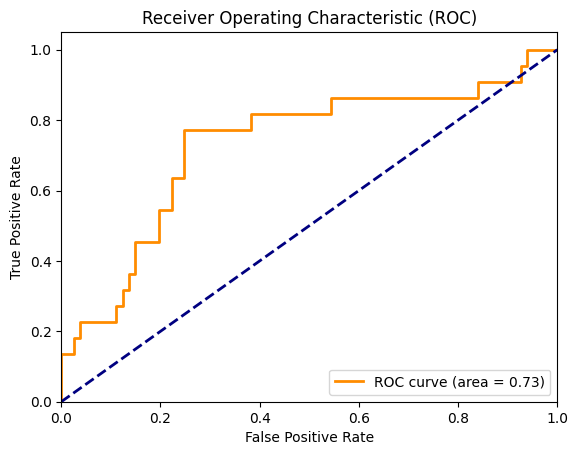

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_meta.predict_proba(X_test[metadataFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### PCA

In [ ]:
k = 5
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# XGBoost model on PCA features
xgb_model_pca = xgb.XGBClassifier(objective = 'binary:logistic', max_depth = 5, eta = 0.1, eval_metric = "logloss", random_state=42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_pca.fit(X_train_fold[pcaFeatures], y_train_fold)

  # Make predictions
  y_pred_fold = xgb_model_pca.predict(X_val_fold[pcaFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-AUC
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_pca, X_train[pcaFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfPca = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfPca)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on the full training set
xgb_model_pca.fit(X_train[pcaFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_pca.predict(X_test[pcaFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.7447
Std. Dev: 0.0169
All accuracy values:  [0.771 0.75  0.75  0.729 0.723]
Average ROC-AUC: 0.6999
Folds avg. metrics:
      metric     Gen-Z  Millenial
0   f1-score  0.836131   0.414278
1  precision  0.792159   0.525397
2     recall  0.886190   0.347436
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.6990
Classification Report:
               precision    recall  f1-score   support

       Gen-Z       0.80      0.83      0.81        81
   Millenial       0.26      0.23      0.24        22

    accuracy                           0.70       103
   macro avg       0.53      0.53      0.53       103
weighted avg       0.68      0.70      0.69       103

Confusion Matrix:
 [[67 14]
 [17  5]]


In [ ]:
reportsDfPca.round(3)

,metric,Gen-Z,Millenial
0,f1-score,0.836,0.414
1,precision,0.792,0.525
2,recall,0.886,0.347


###### ROC

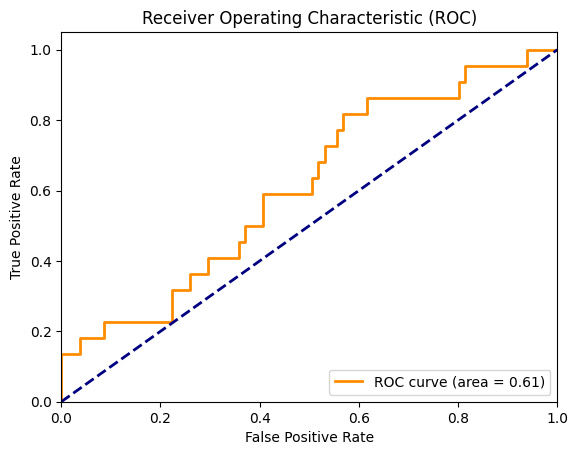

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_pca.predict_proba(X_test[pcaFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### TF-IDF

In [ ]:
k = 5
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# XGBoost model on TF-IDF features
xgb_model_tfidf = xgb.XGBClassifier(objective = "binary:logistic", max_depth = 7, eta = 0.1, random_state = 42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_tfidf.fit(X_train_fold[tfidfFeatures + metadataFeatures], y_train_fold)

  # Make predictions on the test set
  y_pred_fold = xgb_model_tfidf.predict(X_val_fold[tfidfFeatures + metadataFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-AUC
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_tfidf, X_train[tfidfFeatures + metadataFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfTfidf = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfTfidf)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on the full training set
xgb_model_tfidf.fit(X_train[tfidfFeatures + metadataFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_tfidf.predict(X_test[tfidfFeatures + metadataFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.7573
Std. Dev: 0.0315
All accuracy values:  [0.729 0.771 0.812 0.729 0.745]
Average ROC-AUC: 0.7028
Folds avg. metrics:
      metric     Gen-Z  Millenial
0   f1-score  0.850351   0.351579
1  precision  0.778655   0.652381
2     recall  0.937778   0.253846
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.7864
Classification Report:
               precision    recall  f1-score   support

       Gen-Z       0.82      0.94      0.87        81
   Millenial       0.50      0.23      0.31        22

    accuracy                           0.79       103
   macro avg       0.66      0.58      0.59       103
weighted avg       0.75      0.79      0.75       103

Confusion Matrix:
 [[76  5]
 [17  5]]


In [ ]:
reportsDfTfidf.round(3)

,metric,Gen-Z,Millenial
0,f1-score,0.850,0.352
1,precision,0.779,0.652
2,recall,0.938,0.254


###### ROC

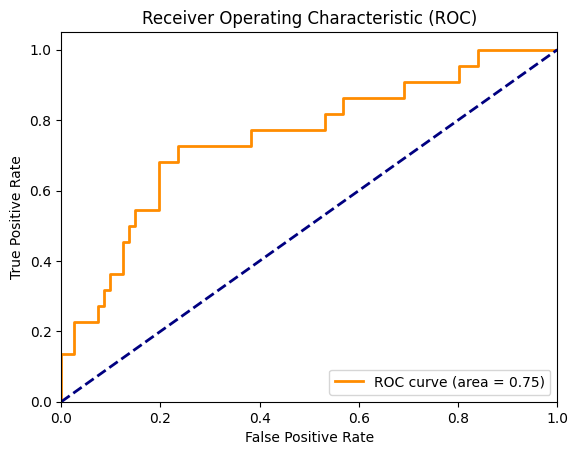

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_tfidf.predict_proba(X_test[tfidfFeatures + metadataFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### TF-IDF + SVD
 Alternative to PCA

In [ ]:
k = 5
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# XGBoost model on TF-IDF features
xgb_model_tfidf_svd = xgb.XGBClassifier(objective = "binary:logistic", max_depth = 7, eta = 0.1, random_state = 42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_tfidf_svd.fit(X_train_fold[svdTfidfFeatures + pcaFeatures], y_train_fold)

  # Make predictions on the test set
  y_pred_fold = xgb_model_tfidf_svd.predict(X_val_fold[svdTfidfFeatures + pcaFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-AUC
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_tfidf_svd, X_train[svdTfidfFeatures + pcaFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfSvd = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfSvd)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on the full training set
xgb_model_tfidf_svd.fit(X_train[svdTfidfFeatures + pcaFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_tfidf_svd.predict(X_test[svdTfidfFeatures + pcaFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.7866
Std. Dev: 0.0276
All accuracy values:  [0.771 0.75  0.792 0.833 0.787]
Average ROC-AUC: 0.7891
Folds avg. metrics:
      metric     Gen-Z  Millenial
0   f1-score  0.868325   0.434766
1  precision  0.796597   0.715714
2     recall  0.954762   0.316667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.7864
Classification Report:
               precision    recall  f1-score   support

       Gen-Z       0.82      0.94      0.87        81
   Millenial       0.50      0.23      0.31        22

    accuracy                           0.79       103
   macro avg       0.66      0.58      0.59       103
weighted avg       0.75      0.79      0.75       103

Confusion Matrix:
 [[76  5]
 [17  5]]


In [ ]:
reportsDfSvd.round(3)

,metric,Gen-Z,Millenial
0,f1-score,0.868,0.435
1,precision,0.797,0.716
2,recall,0.955,0.317


###### ROC

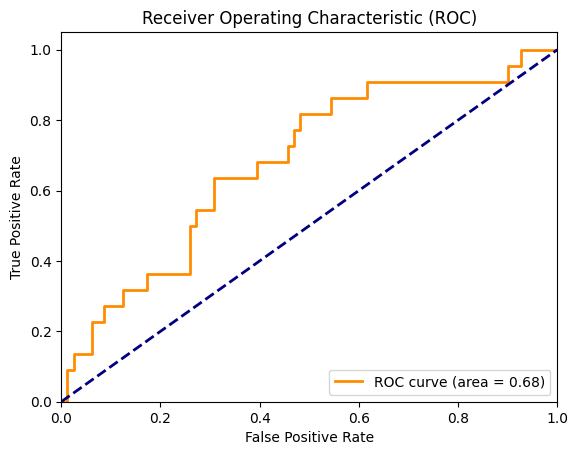

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_tfidf_svd.predict_proba(X_test[svdTfidfFeatures + pcaFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### Word Embeddings

In [ ]:
k = 5
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Lists to store results for each fold
accuracies = []
reports = []

# XGBoost model on Word Embeddings
xgb_model_embed = xgb.XGBClassifier(objective='binary:logistic', max_depth = 7, eta = 0.1, random_state=42)

# Iterate through folds
for train_index, val_index in skf.split(X_train, y_train):
  # Get the fold's training and validation data
  X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
  y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]

  # Train on folds
  xgb_model_embed.fit(X_train_fold[embeddingFeatures + metadataFeatures], y_train_fold)

  # Evaluate on the validation set
  y_pred_fold = xgb_model_embed.predict(X_val_fold[embeddingFeatures + metadataFeatures])

  # Evaluate the fold's performance
  accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
  reports.append(classification_report(y_val_fold, y_pred_fold, target_names=classes, output_dict=True))

print(f"Folds mean accuracy: {np.mean(accuracies):.4f}")
print(f"Std. Dev: {np.std(accuracies):.4f}")
print(f"All accuracy values: ", np.round(accuracies, 3))
# Use the classification reports to find the average precision, recall, and f1-score per class
dfs = []
for report in reports:
  df = pd.DataFrame(report).drop(columns = ["accuracy",	"macro avg",	"weighted avg"]).drop(index = ["support"]).reset_index().rename({"index": "metric"}, axis = 1)
  dfs.append(df)
# Combine
reportsDf = pd.concat(dfs)

# CV ROC-
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cvScores = cross_val_score(xgb_model_embed, X_train[embeddingFeatures + metadataFeatures], y_train, cv=cv, scoring='roc_auc')
print(f"Average ROC-AUC: {np.mean(cvScores):.4f}")

# Group by metric and take the mean
reportsDfEmbed = reportsDf.groupby("metric").mean().reset_index()
print("Folds avg. metrics:")
print(reportsDfEmbed)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Train on the full training set
xgb_model_embed.fit(X_train[embeddingFeatures + metadataFeatures], y_train)
# Evaluate model performance on the test dataset
y_pred = xgb_model_embed.predict(X_test[embeddingFeatures + metadataFeatures])
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Folds mean accuracy: 0.7866
Std. Dev: 0.0203
All accuracy values:  [0.812 0.792 0.792 0.75  0.787]
Average ROC-AUC: 0.7655
Folds avg. metrics:
      metric     Gen-Z  Millenial
0   f1-score  0.863683   0.498377
1  precision  0.814611   0.668615
2     recall  0.920476   0.411538
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 0.7767
Classification Report:
               precision    recall  f1-score   support

       Gen-Z       0.84      0.89      0.86        81
   Millenial       0.47      0.36      0.41        22

    accuracy                           0.78       103
   macro avg       0.65      0.63      0.64       103
weighted avg       0.76      0.78      0.77       103

Confusion Matrix:
 [[72  9]
 [14  8]]


In [ ]:
reportsDfEmbed.round(3)

,metric,Gen-Z,Millenial
0,f1-score,0.864,0.498
1,precision,0.815,0.669
2,recall,0.920,0.412


###### ROC

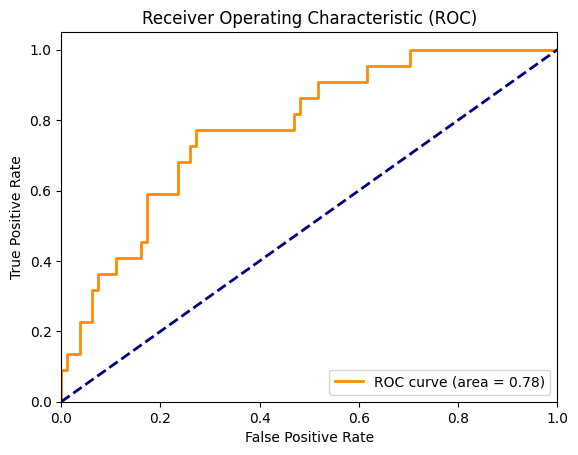

In [ ]:
# Prediction prob
y_pred_prob = xgb_model_embed.predict_proba(X_test[embeddingFeatures + metadataFeatures])[:, 1]
# Compute the ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### Hyperparamter Tuning
Grid Search

In [ ]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(estimator=xgb_model_embed, param_grid=param_grid, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


              precision    recall  f1-score   support

           0       0.84      0.86      0.85        96
           1       0.41      0.36      0.38        25

    accuracy                           0.76       121
   macro avg       0.62      0.61      0.62       121
weighted avg       0.75      0.76      0.75       121

[[83 13]
 [16  9]]


### Prediction
1. Use the metadata model to predict
2. Next best: Use the XGBoost with Embeddings model to predict the missing labels

In [ ]:
# Create a dataframe with the missing ages
toPredictDf = authorsWithTextDf[authorsWithTextDf.age_group.isna()]

"""
# Pass the df through the PCA pipeline
toPredictPca = pcaPipeline.transform(toPredictDf)[:, :nComponents]
toPredictPcaDf = pd.DataFrame(toPredictPca, columns = pcaCols, index = toPredictDf.index)
"""
# Create GloVe embeddings for tweets
embeds = toPredictDf["cleaned_text"].apply(get_tweet_embedding)
# Convert to dataframe
toPredEmbedsDf = pd.DataFrame(embeds.tolist(), columns = [f"embedding_{i}" for i in range(gloveModel.vector_size)])

# Use the preprocessor from the metadata section
toPredictMetadataDf = pd.DataFrame(preprocessor.transform(toPredictDf), columns = preprocessor.get_feature_names_out())
# Combine this with the metadataFeatures
combinedDf = pd.concat([toPredEmbedsDf, toPredictMetadataDf[metadataFeatures]], axis = 1)

# predict
y_pred = xgb_model_embed.predict(combinedDf)
# inverse the labels
y_pred = le.inverse_transform(y_pred)
# Assign the labels to the dataframe
toPredictDf["age_group"] = y_pred

# Combine with the original authorsTestDf dataframe
fullDf = pd.concat([authorsWithTextDf[authorsWithTextDf.age_group.notna()], toPredictDf], axis = 0, ignore_index=True)
# Assign the majority group to the na on age_group
print("Missing age_groups:", fullDf.age_group.isna().sum())
fullDf.age_group.fillna(fullDf.age_group.value_counts().idxmax(), inplace=True)

# Check
print("Final dataset shape:", fullDf.shape)
fullDf.age_group.value_counts()

Missing age_groups: 0
Final dataset shape: (6536, 31)


<ipython-input-86-35e967737347>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPredictDf["age_group"] = y_pred


age_group
Gen-Z        4657
Millenial    1879
Name: count, dtype: int64

In [ ]:
# Create a dataframe with the missing ages
toPredictDf = authorsWithTextDf[authorsWithTextDf.age_group.isna()]
# Use the preprocessor from the metadata section
toPredictMetadataDf = pd.DataFrame(preprocessor.transform(toPredictDf), columns = preprocessor.get_feature_names_out())
# predict
y_pred = xgb_model_meta.predict(toPredictMetadataDf)
# inverse the labels
y_pred = le.inverse_transform(y_pred)
# Assign the labels to the dataframe
toPredictDf["age_group"] = y_pred

# Combine with the original authorsTestDf dataframe
fullDf = pd.concat([authorsWithTextDf[authorsWithTextDf.age_group.notna()], toPredictDf], axis = 0, ignore_index=True)
# Assign the majority group to the na on age_group
print("Missing age_groups:", fullDf.age_group.isna().sum())
fullDf.age_group.fillna(fullDf.age_group.value_counts().idxmax(), inplace=True)

# Check
print("Final dataset shape:", fullDf.shape)
fullDf.age_group.value_counts()

Missing age_groups: 0
Final dataset shape: (5612, 31)


<ipython-input-42-bfcab01254bd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPredictDf["age_group"] = y_pred


,count
age_group,
Gen-Z,4283
Millenial,1329


##### Save

In [ ]:
# Save the output to a pickle file (remove the text to reduce the file size)
fullDf.drop(columns = ["cleaned_text"]).to_pickle(os.path.join(demographicsDir, "authorAge.pickle"))

#### Validate

In [ ]:
print("Final Shape:", fullDf.shape)
fullDf.age_group.value_counts()

Final Shape: (5612, 31)


,count
age_group,
Gen-Z,4283
Millenial,1329
